In [1]:
from IPython.display import Image
%matplotlib inline

# Step by Step

First, we should have a look at my 'test.pb' graph by tensorboard

Generate the event directory of 'test.pb': 

```$ python tools/import_pb_to_tensorboard.py --model_dir='examples/test.pb' --log_dir='log_test'```

Visualize by running: 

```$ tensorboard --logdir=log_test```

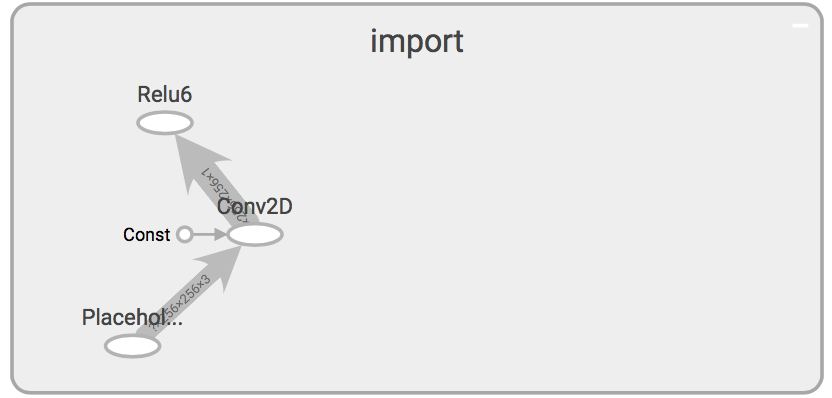

In [11]:
Image(filename='../examples/test_graph.png', width=600) 

Assume that we want to concatenate our Placeholder input and Relu6, so we need to add a concat op into 'test.pb'. However, the 'test.pb' file is a binary format, it's difficult for human to read，to say nothing to change. For that, I think we can convert it into 'text.pbtxt' the easier format for us to know what it is, and edit it.

In [3]:
import tensorflow as tf
graph_path = '../examples/test.pb'
with tf.Graph().as_default() as g_1:
    g1_def = tf.GraphDef()
    with open(graph_path, 'rb') as f:
        g1_def.ParseFromString(f.read())
        _ = tf.import_graph_def(g1_def, name="")
        sess = tf.Session()
        tf.train.write_graph(sess.graph, '../examples','test.pbtxt')

/Library/Python/2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Run the codes above, and read our test.pbtxt  

```$ vim examples/test.pbtxt```

We can see somethings as following:

```
node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }   
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }   
        dim {
          size: 256 
        }   
        dim {
          size: 256 
        }   
        dim {
          size: 3
        }   
      }   
    }   
  }
}
node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }   
  }
  attr {
    key: "value"
    
......

```

And then, we also want to know what is the 'concat' op look like in the '.pbtxt' file, so we can make a small demo for it as following:

In [6]:
with tf.Graph().as_default() as g2:
    x = tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 3])
    # the relu6 output channel size is 13, you can get this info from tensorboard.
    y = tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 13])
    z = tf.concat([x,y],axis=-1)
    sess1 = tf.Session()
    tf.train.write_graph(sess1.graph, '../examples','demo.pbtxt')

Open the 'demo.pbtxt' you may see somethings as following:

```
node {
  name: "concat/axis"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }   
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }   
        int_val: -1
      }   
    }   
  }
}
node {
  name: "concat"
  op: "ConcatV2"
  input: "Placeholder"
  input: "Placeholder_1"
  input: "concat/axis"
  attr {
    key: "N" 
    value {
      i: 2
    }   
  }
  attr {
    key: "T" 
    value {
      type: DT_FLOAT
    }   
  }
  attr {
  
.........
```

So, what can we do next? I think it's quite clear for everyone, we just copy the code about 'concat' op into 'test.pbtxt' and modify the inputs info, then we will get out target graph file. I give you some tips of code in 'test.pbtxt' as following:

```
......

node {
  name: "concat"
  op: "ConcatV2"
  input: "Relu6"
  input: "Placeholder"
  input: "concat/axis"
  attr {
    key: "N" 
    value {
      i: 2
    }   
  }
  attr {
    key: "T" 
    value {
      type: DT_FLOAT
    }   
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }   
  }
}

......
```

At last, we need to convert our 'test.pbtxt' back into 'test.pb' file, and to tell the cliped one, the new 'test.pb' I will rename it as 'test_cliped.pb'

In [7]:
from google.protobuf import text_format
graph_path = '../examples/test.pbtxt'
with tf.Graph().as_default() as g_1:
    g1_def = tf.GraphDef()
    with open(graph_path, 'rb') as f:
        text_format.Merge(f.read(), g1_def)
        _ = tf.import_graph_def(g1_def, name="")
        sess = tf.Session()
        tf.train.write_graph(sess.graph, '../examples','test_cliped.pb', as_text=False)

Using tools to check our modification.

`$ python tools/import_pb_to_tensorboard.py --model_dir='examples/test_cliped.pb' --log_dir='log_test_cliped'`

`$ tensorboard --logdir=log_test_cliped`

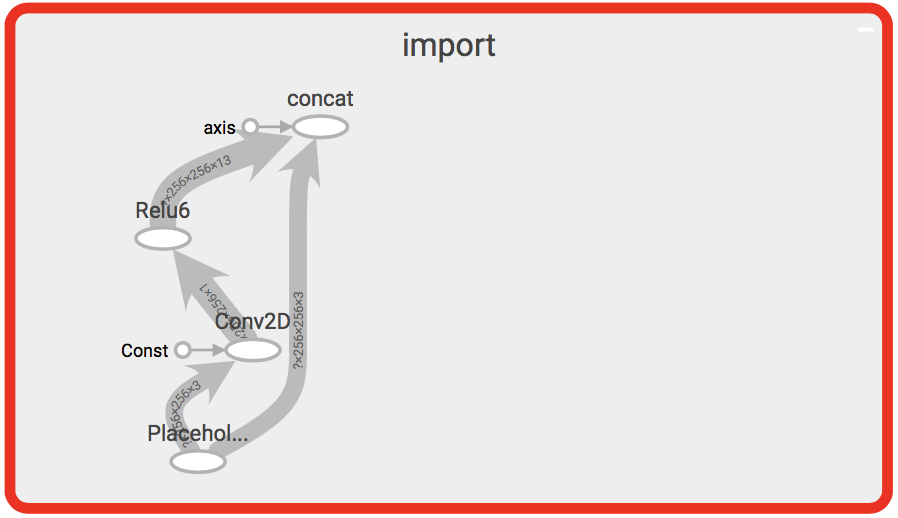

In [10]:
Image(filename='../examples/test_cliped_graph.png', width=500) 

## Bravo! 

But it may not really mean a happy ending before we check the cliped graph work well as our expectation. Actually, we may meet lots of probelms about the wrong result from our cliped graph, and we should keep checking and refining our graph for our expectaton.

## FIN.